Loaded isotherm 4.5 with 15863 points.
After NaN cleaning: 15863 points.
Silhouette score (feature space): 0.260

Cluster summary (correlate IDs with the plot):
 kmeans_cluster    n     x_mean     y_mean   sd_mean   sd_std
              0 1738 156.747474 113.859068  1.480864 0.189562
              1 6127 216.510988 118.495282  0.226775 0.510618
              2 3593 145.543560 100.517663  1.108831 0.314342
              3   11 187.050343  47.962656 17.214683 5.819602
              4 4394 213.312917 115.711415  0.300042 0.507497


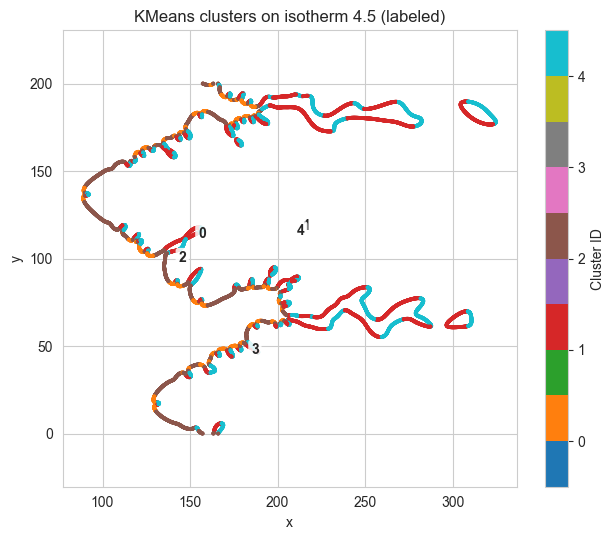


Cluster 0: n = 1738
  Top features (mRMR order):
    01. H2O   (MI relevance = 1.0718)
    02. strain_rate   (MI relevance = 0.8199)
    03. H2O2   (MI relevance = 0.7796)
    04. FDS_diff_velocity_term   (MI relevance = 1.0547)
    05. gradT   (MI relevance = 0.9938)
    06. stretch_rate   (MI relevance = 0.7946)
    07. flow_velocity_normal   (MI relevance = 0.5697)
    08. FDS_src_term   (MI relevance = 0.9441)
    09. HO2   (MI relevance = 1.0281)
    10. v   (MI relevance = 0.5574)


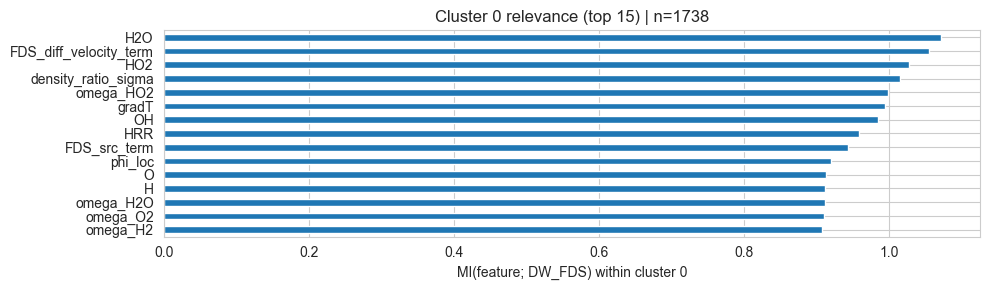


Cluster 1: n = 6127
  Top features (mRMR order):
    01. FDS_diffusion_term   (MI relevance = 3.4629)
    02. stretch_rate   (MI relevance = 1.0110)
    03. H2O   (MI relevance = 1.7823)
    04. u   (MI relevance = 1.4796)
    05. total_heat_conduction   (MI relevance = 1.7221)
    06. curvature   (MI relevance = 1.0615)
    07. FDS_diff_velocity_term   (MI relevance = 1.4231)
    08. abs_flame_prop_vel_normal   (MI relevance = 0.8573)
    09. O2_diffusion_total   (MI relevance = 1.4054)
    10. vorticity   (MI relevance = 1.7370)


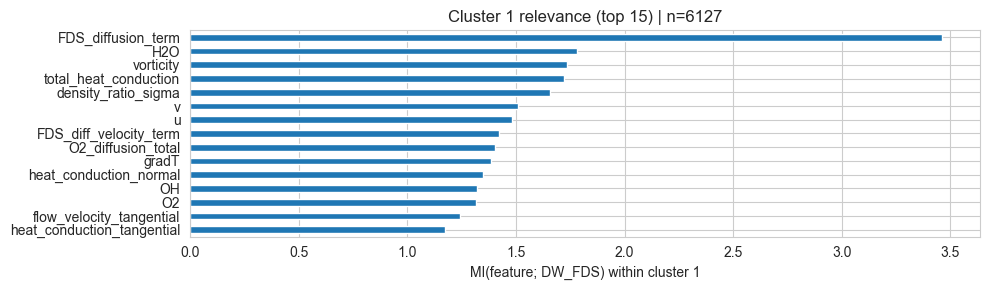


Cluster 2: n = 3593
  Top features (mRMR order):
    01. H2O   (MI relevance = 1.6714)
    02. strain_rate   (MI relevance = 1.1381)
    03. FDS_diff_velocity_term   (MI relevance = 1.6182)
    04. H2O2   (MI relevance = 1.3048)
    05. v   (MI relevance = 1.2124)
    06. gradT   (MI relevance = 1.3602)
    07. FDS_src_term   (MI relevance = 1.5046)
    08. HO2   (MI relevance = 1.5517)
    09. flow_velocity_normal   (MI relevance = 1.0193)
    10. H2_diffusion_total   (MI relevance = 1.0056)


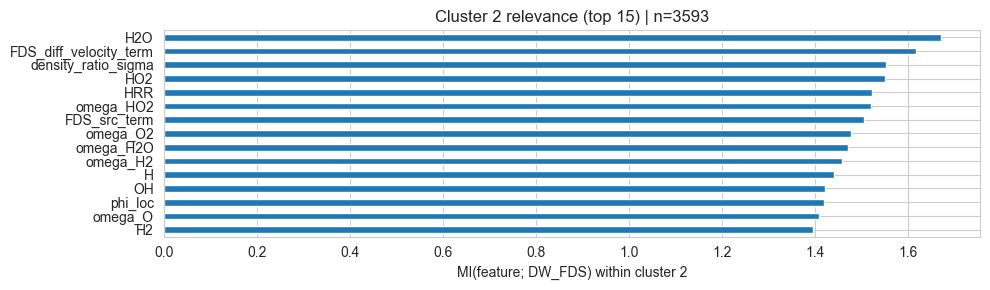


Cluster 3: n = 11
  Skipping mRMR (too few samples; MIN_CLUSTER_SAMPLES=300)

Cluster 4: n = 4394
  Top features (mRMR order):
    01. FDS_diffusion_term   (MI relevance = 3.0190)
    02. v   (MI relevance = 1.3989)
    03. stretch_rate   (MI relevance = 1.1059)
    04. H2O   (MI relevance = 1.5298)
    05. curvature   (MI relevance = 1.1805)
    06. total_heat_conduction   (MI relevance = 1.5142)
    07. abs_flame_prop_vel_normal   (MI relevance = 0.6579)
    08. vorticity   (MI relevance = 1.1207)
    09. tangential_strain_rate   (MI relevance = 1.0149)
    10. O2_diffusion_total   (MI relevance = 1.2718)


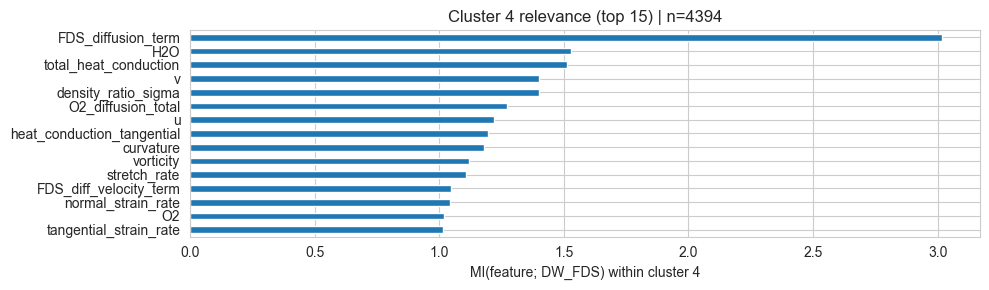


Summary (mRMR features per cluster):
 cluster  rank                   feature  n_cluster
       0     1                       H2O       1738
       0     2               strain_rate       1738
       0     3                      H2O2       1738
       0     4    FDS_diff_velocity_term       1738
       0     5                     gradT       1738
       0     6              stretch_rate       1738
       0     7      flow_velocity_normal       1738
       0     8              FDS_src_term       1738
       0     9                       HO2       1738
       0    10                         v       1738
       1     1        FDS_diffusion_term       6127
       1     2              stretch_rate       6127
       1     3                       H2O       6127
       1     4                         u       6127
       1     5     total_heat_conduction       6127
       1     6                 curvature       6127
       1     7    FDS_diff_velocity_term       6127
       1     8 abs_flame_p

In [2]:
# ============================================================
# One isotherm -> KMeans clustering -> labeled cluster plot (IDs on x-y)
# -> per-cluster mRMR vs Sd (DW_FDS) and top-feature summaries
# ============================================================

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import silhouette_score


# =========================
# USER SETTINGS
# =========================

BASE_DIR = Path("../isocontours")

TARGET_VAR = "DW_FDS"          # Sd-like target column
ISOLEVEL = 4.5                 # <-- choose ONE isotherm
N_CLUSTERS = 5                 # <-- KMeans clusters

# clustering excludes target to avoid leakage; optionally exclude x,y,z for state-space clustering
COLS_EXCLUDE_GLOBAL = [
    "x", "y", "z",
    TARGET_VAR,
    "N2", "omega_N2",
    "p", "T", "c_iso"
]

# If True -> clustering includes x,y,z (spatial clustering).
# If False -> clustering uses only state/chemistry/transport features (recommended for "regimes").
CLUSTER_ON_SPATIAL = False

# mRMR: how many features to report per cluster
K_SELECT_PER_CLUSTER = 10

# Minimum samples in a cluster to trust MI (otherwise skip)
MIN_CLUSTER_SAMPLES = 300

RANDOM_STATE = 0

# -------------------------
# Case config (adjust naming to your folders)
# -------------------------

@dataclass(frozen=True)
class CaseConfig:
    phi: float = 0.40
    lat_size: str = "100"
    time_step: int = 212
    post: bool = True
    multiple_runs: bool = False
    n_RUN: int = 1
    Soret_term: bool = False
    Soret_positive: bool = False
    h_tag: str = "h400"


CASE = CaseConfig(
    phi=0.40,
    lat_size="200",
    time_step=230,
    post=True,
    multiple_runs=False,
    n_RUN=2,
    Soret_term=False,
    Soret_positive=False,
)


# =========================
# IO helpers
# =========================

def case_folder(cfg: CaseConfig) -> Path:
    phi_dir = BASE_DIR / f"phi{cfg.phi:.2f}"

    if cfg.Soret_term and cfg.Soret_positive:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref_Soret_positive"
    elif cfg.Soret_term:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"
    else:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"

    if cfg.multiple_runs:
        folder = folder / f"RUN0{cfg.n_RUN}"

    return folder


def isofile_name(cfg: CaseConfig, c_val: float) -> str:
    if cfg.post:
        return f"extracted_flame_front_post_{cfg.time_step}_iso_{c_val}.csv"
    return f"extracted_flame_front_{cfg.time_step}_iso_{c_val}.csv"


def load_isotherm(cfg: CaseConfig, c_val: float) -> pd.DataFrame:
    fpath = case_folder(cfg) / isofile_name(cfg, c_val)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing file:\n  {fpath}")
    df = pd.read_csv(fpath).copy()
    df["c_iso"] = float(c_val)
    return df


# =========================
# Feature utilities
# =========================

def numeric_feature_list(df: pd.DataFrame, exclude: List[str]) -> List[str]:
    feats = []
    for c in df.columns:
        if c in exclude:
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            feats.append(c)
    return feats


def clean_xy(df: pd.DataFrame, features: List[str], target: str) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    dfc = df.dropna(subset=features + [target]).copy()
    X = dfc[features].to_numpy()
    y = dfc[target].to_numpy()
    return X, y, dfc


# =========================
# mRMR (within a cluster)
# =========================

def mrmr_greedy(
    X: np.ndarray,
    y: np.ndarray,
    feature_cols: List[str],
    k_select: int,
    random_state: int = 0
) -> Tuple[List[str], pd.Series]:
    """
    Greedy mRMR: score(j) = I(Xj;y) - mean_{s in selected} I(Xj;Xs)
    """
    n_samples, n_features = X.shape
    k_select = int(min(k_select, n_features))

    mi_ft = mutual_info_regression(X, y, random_state=random_state)
    mi_rank = pd.Series(mi_ft, index=feature_cols).sort_values(ascending=False)

    # redundancy MI matrix
    mi_ff = np.zeros((n_features, n_features), dtype=float)
    for i in range(n_features):
        Xi = X[:, [i]]
        for j in range(i + 1, n_features):
            Xj = X[:, j]
            mi_ij = mutual_info_regression(Xi, Xj, random_state=random_state)[0]
            mi_ff[i, j] = mi_ij
            mi_ff[j, i] = mi_ij

    selected_idx: List[int] = []
    selected_feats: List[str] = []

    for _ in range(k_select):
        best_score = -np.inf
        best_j: Optional[int] = None

        for j in range(n_features):
            if j in selected_idx:
                continue
            relevance = mi_ft[j]
            redundancy = 0.0 if len(selected_idx) == 0 else float(np.mean([mi_ff[j, s] for s in selected_idx]))
            score = relevance - redundancy

            if score > best_score:
                best_score = score
                best_j = j

        if best_j is None:
            break

        selected_idx.append(best_j)
        selected_feats.append(feature_cols[best_j])

    return selected_feats, mi_rank


# =========================
# Main workflow
# =========================

def main():
    # 1) Load one isotherm
    df = load_isotherm(CASE, ISOLEVEL)
    print(f"Loaded isotherm {ISOLEVEL} with {len(df)} points.")
    if TARGET_VAR not in df.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found in columns.")

    # 2) Choose clustering features (exclude target; optionally include x,y,z)
    exclude = list(COLS_EXCLUDE_GLOBAL)
    if CLUSTER_ON_SPATIAL:
        for c in ["x", "y", "z"]:
            if c in exclude:
                exclude.remove(c)

    cluster_features = numeric_feature_list(df, exclude=exclude)
    if len(cluster_features) == 0:
        raise ValueError("No numeric clustering features left after exclusions.")

    # Clean consistently: require both clustering features and target to be non-NaN
    dfc = df.dropna(subset=cluster_features + [TARGET_VAR]).copy()
    print(f"After NaN cleaning: {len(dfc)} points.")
    X_cluster = dfc[cluster_features].to_numpy()

    # 3) Scale + KMeans
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_cluster)

    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=20)
    labels = kmeans.fit_predict(Xs)
    dfc["kmeans_cluster"] = labels

    # Diagnostics
    if N_CLUSTERS >= 2 and len(dfc) > N_CLUSTERS:
        sil = silhouette_score(Xs, labels)
        print(f"Silhouette score (feature space): {sil:.3f}")

    # ============================================================
    # Cluster summary + labeled physical-space plot
    # ============================================================
    summary_cols = ["kmeans_cluster"]
    if "x" in dfc.columns:
        summary_cols.append("x")
    if "y" in dfc.columns:
        summary_cols.append("y")
    summary_cols.append(TARGET_VAR)

    # robust aggregation even if x/y are missing
    agg_dict = {
        "kmeans_cluster": ("kmeans_cluster", "size"),
        TARGET_VAR: (TARGET_VAR, "mean"),
    }
    if "x" in dfc.columns:
        agg_dict["x"] = ("x", "mean")
    if "y" in dfc.columns:
        agg_dict["y"] = ("y", "mean")

    cluster_summary = (
        dfc[summary_cols]
        .groupby("kmeans_cluster")
        .agg(
            n=("kmeans_cluster", "size"),
            x_mean=("x", "mean") if "x" in dfc.columns else (TARGET_VAR, "size"),
            y_mean=("y", "mean") if "y" in dfc.columns else (TARGET_VAR, "size"),
            sd_mean=(TARGET_VAR, "mean"),
            sd_std=(TARGET_VAR, "std"),
        )
        .reset_index()
    )
    if "x" not in dfc.columns:
        cluster_summary = cluster_summary.drop(columns=["x_mean"])
    if "y" not in dfc.columns:
        cluster_summary = cluster_summary.drop(columns=["y_mean"])

    print("\nCluster summary (correlate IDs with the plot):")
    print(cluster_summary.to_string(index=False))

    # Labeled plot in physical space (x-y) so you can correlate cluster IDs
    if "x" in dfc.columns and "y" in dfc.columns:
        plt.figure(figsize=(6.5, 5.5))
        sc = plt.scatter(
            dfc["x"], dfc["y"],
            c=dfc["kmeans_cluster"],
            s=3,
            cmap="tab10",
            vmin=-0.5,
            vmax=N_CLUSTERS - 0.5,
        )
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"KMeans clusters on isotherm {ISOLEVEL} (labeled)")

        cbar = plt.colorbar(sc, ticks=np.arange(N_CLUSTERS))
        cbar.set_label("Cluster ID")
        cbar.ax.set_yticklabels([str(i) for i in range(N_CLUSTERS)])

        centroids_xy = (
            dfc.groupby("kmeans_cluster")[["x", "y"]]
            .mean()
            .reset_index()
        )
        for _, row in centroids_xy.iterrows():
            cl = int(row["kmeans_cluster"])
            plt.text(
                row["x"], row["y"], str(cl),
                ha="center", va="center",
                fontsize=10, fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, ec="none"),
            )

        plt.tight_layout()
        plt.show()

    # 4) For each cluster: mRMR vs Sd within that cluster
    results: Dict[int, Dict[str, object]] = {}

    for cl in range(N_CLUSTERS):
        sub = dfc[dfc["kmeans_cluster"] == cl].copy()
        n_cl = len(sub)
        print(f"\nCluster {cl}: n = {n_cl}")

        if n_cl < MIN_CLUSTER_SAMPLES:
            print(f"  Skipping mRMR (too few samples; MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
            continue

        mrmr_features = cluster_features
        X, y, sub_clean = clean_xy(sub, mrmr_features, TARGET_VAR)

        selected, mi_rank = mrmr_greedy(
            X=X,
            y=y,
            feature_cols=mrmr_features,
            k_select=K_SELECT_PER_CLUSTER,
            random_state=RANDOM_STATE,
        )

        print("  Top features (mRMR order):")
        for i, f in enumerate(selected, 1):
            print(f"    {i:02d}. {f}   (MI relevance = {mi_rank.loc[f]:.4f})")

        results[cl] = {
            "n": n_cl,
            "selected_features": selected,
            "mi_rank": mi_rank,
        }

        # Plot MI relevance for top N within this cluster
        topN = min(15, len(mi_rank))
        plt.figure(figsize=(10, 3))
        mi_rank.head(topN).iloc[::-1].plot(kind="barh")
        plt.xlabel(f"MI(feature; {TARGET_VAR}) within cluster {cl}")
        plt.title(f"Cluster {cl} relevance (top {topN}) | n={n_cl}")
        plt.tight_layout()
        plt.show()

    # Summary table of selected features per cluster
    if results:
        rows = []
        for cl, d in results.items():
            for rank, feat in enumerate(d["selected_features"], 1):
                rows.append({"cluster": cl, "rank": rank, "feature": feat, "n_cluster": d["n"]})
        summary = pd.DataFrame(rows)
        print("\nSummary (mRMR features per cluster):")
        print(summary.to_string(index=False))
    else:
        print("\nNo clusters met MIN_CLUSTER_SAMPLES; no mRMR results to report.")


if __name__ == "__main__":
    main()
